In [8]:
import pandas as pd
import torch
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv("data/stan_data_covariates.csv", index_col=0)
df

,y,N,i,d,K,x
0,0.196,4404,1,0,2,2
1,0.120,4404,1,0,2,2
2,0.102,4404,1,0,2,2
3,0.284,4404,1,0,2,2
4,0.075,4404,1,0,2,2
...,...,...,...,...,...,...
4399,0.402,4404,1,1,2,1
4400,1.005,4404,1,1,2,1
4401,0.853,4404,0,0,2,1
4402,1.482,4404,0,0,2,1


<AxesSubplot:xlabel='y', ylabel='Count'>

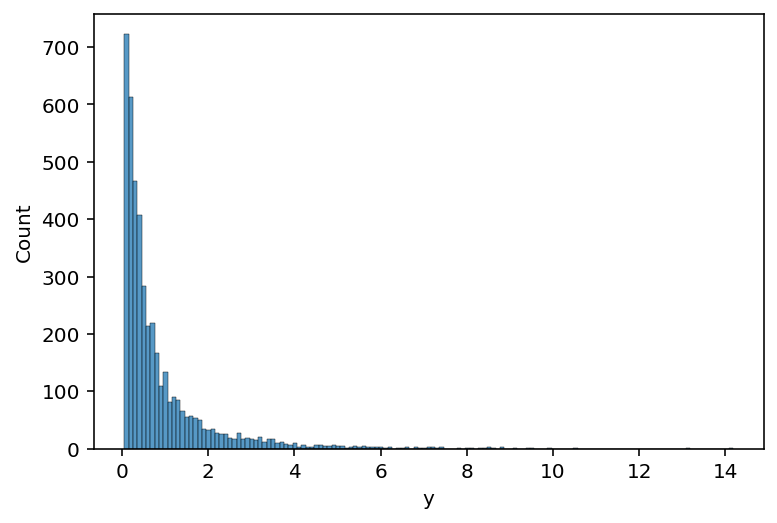

In [11]:
sns.histplot(df.y)

In [44]:
# stan_code = """
#         data {
#             int<lower=0> N; // number of observations
#             vector[N] y;    // observations (aggregated)
#             vector[N] i;
#             vector[N] d;
#             int<lower=0> K; // number of groups (conditions)
#             int<lower=1,upper=K> x[N]; // indicators for groups (conditions)
#         }
#         parameters {
#             real<lower=0> alpha[K];        // pooled alpha (shape)
#             real beta_0[K];
#             real beta_i[K];
#             real beta_d[K];
#         }
#         model {
#             for (k in 1:K){
#                 alpha[k] ~ normal(0, 10);
#                 beta_0[k] ~ normal(0, 10);
#                 beta_i[k] ~ normal(0, 10);
#                 beta_d[k] ~ normal(0, 10);
#             }

#             for (n in 1:N){
#                 y[n] ~ weibull(alpha[x[n]], exp(-(beta_0[x[n]] + beta_i[x[n]]*i[n] + beta_d[x[n]]*d[n])/alpha[x[n]]));  // likelihood / observation model
#             }
#         }

#         generated quantities {
#             vector[N] log_lik;
#             vector[N] y_rep;
#             int<lower = 0, upper = 1> mean_gt;
#             int<lower = 0, upper = 1> sd_gt;
#             for (n in 1:N){
#                 log_lik[n] = weibull_lpdf(y[n] | alpha[x[n]], exp(-(beta_0[x[n]] + beta_i[x[n]]*i[n] + beta_d[x[n]]*d[n])/alpha[x[n]])); 
#                 y_rep[n] = weibull_rng(alpha[x[n]], exp(-(beta_0[x[n]] + beta_i[x[n]]*i[n] + beta_d[x[n]]*d[n])/alpha[x[n]]));
#                 }
#             mean_gt = mean(y_rep) > mean(y);
#             sd_gt = sd(y_rep) > sd(y);
#         }

In [45]:
#K = 2  # Number of condition
# y[n] ~ weibull(alpha[x[n]], exp(-(beta_0[x[n]] + beta_i[x[n]]*i[n] + beta_d[x[n]]*d[n])/alpha[x[n]]));  // likelihood / observation model
#            }

In [91]:
class SimpleModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.log_k = torch.nn.Parameter(torch.zeros(1))
        self.log_lbda = torch.nn.Parameter(torch.zeros(1))
#         self.mu_alpha = torch.nn.Parameter(torch.zeros(1))
#         self.mu_beta_0 = torch.nn.Parameter(torch.zeros(1))
#         self.mu_beta_i = torch.nn.Parameter(torch.zeros(1))
#         self.mu_beta_d = torch.nn.Parameter(torch.zeros(1))
        
#         self.logvar_alpha = torch.nn.Parameter(torch.zeros(1))
#         self.logvar_beta_0 = torch.nn.Parameter(torch.zeros(1))
#         self.logvar_beta_i = torch.nn.Parameter(torch.zeros(1))
#         self.logvar_beta_d = torch.nn.Parameter(torch.zeros(1))

    def forward(self, i, d, y, n_sample=100):
        
#         eps = 1e-8
        
#         sd_alpha = torch.exp(0.5*self.logvar_alpha) + eps
#         sd_beta_0 = torch.exp(0.5*self.logvar_beta_0) + eps
#         sd_beta_i = torch.exp(0.5*self.logvar_beta_i) + eps
#         sd_beta_d = torch.exp(0.5*self.logvar_beta_d) + eps
        
#         alpha = torch.randn(size=(n_sample, 1))*sd_alpha + self.mu_alpha
#         beta_0 = torch.randn(size=(n_sample, 1))*sd_beta_0 + self.mu_beta_0
#         beta_i = torch.randn(size=(n_sample, 1))*sd_beta_i + self.mu_beta_i
#         beta_d = torch.randn(size=(n_sample, 1))*sd_beta_d + self.mu_beta_d
        
#         pen_alpha = torch.distributions.Normal(self.mu_alpha, sd_alpha).log_prob(alpha)
#         pen_beta_0 = torch.distributions.Normal(self.mu_beta_0, sd_beta_0).log_prob(beta_0)
#         pen_beta_i = torch.distributions.Normal(self.mu_beta_i, sd_beta_i).log_prob(beta_i)
#         pen_beta_d = torch.distributions.Normal(self.mu_beta_d, sd_beta_d).log_prob(beta_d)
        
#         pen = pen_alpha + pen_beta_0 + pen_beta_i + pen_beta_d
        
#         k = torch.exp(alpha) + eps # alpha in Stan, k/shape in Wikipedia, k/contentration in Torch
#         lbda = torch.exp(-(beta_0 + beta_i*i + beta_d*d) / k) # sigma in Stan, lambda/scale in Wikipdedia, scale in Torch
        k = self.log_k.exp()  
        lbda = self.log_lbda.exp()  
        lls = torch.distributions.Weibull(concentration=k, scale=lbda).log_prob(y).sum()  # axis=-1
        return - lls # + pen.mean()

In [92]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.log_k_mu = torch.nn.Parameter(torch.zeros(1))
        self.log_k_logvar = torch.nn.Parameter(torch.zeros(1))
        
        self.log_lbda_mu = torch.nn.Parameter(torch.zeros(1))
        self.log_lbda_logvar = torch.nn.Parameter(torch.zeros(1))

    def forward(self, i, d, y, n_sample=100):
        
        log_k_sd = torch.exp(0.5*self.log_k_logvar)
        log_lbda_sd = torch.exp(0.5*self.log_lbda_logvar)
        
        log_k = torch.randn(size=(n_sample, 1))*log_k_sd + self.log_k_mu
        log_lbda = torch.randn(size=(n_sample, 1))*log_lbda_sd + self.log_lbda_mu

        pen_k = torch.distributions.Normal(self.log_k_mu, log_k_sd).log_prob(log_k)
        pen_lbda = torch.distributions.Normal(self.log_lbda_mu, log_lbda_sd).log_prob(log_lbda)
        
        pen_mean = (pen_k + pen_lbda).mean()
        
        k = log_k.exp()
        lbda = log_lbda.exp()
        
        lls = torch.distributions.Weibull(concentration=k, scale=lbda).log_prob(y).sum(axis=-1)
        print(lls.shape)
        mean_lls = lls.mean()
        print(mean_lls, pen_mean)
        return - mean_lls + pen_mean

In [93]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, condition):

        self.i, self.d, self.y = self.load_data(condition)

    def load_data(self, condition):

        df = pd.read_csv("data/stan_data_covariates.csv", index_col=0)
        df = df[df.x == condition]
        i = torch.tensor(df.i.values, dtype=torch.float)
        d = torch.tensor(df.d.values, dtype=torch.float)
        y = torch.tensor(df.y.values, dtype=torch.float)

        # y = torch.distributions.Weibull()

        return i, d, y
    
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.i[idx], self.d[idx], self.y[idx]

In [94]:
class FakeDataset(torch.utils.data.Dataset):

    def __init__(self, condition):

        self.i, self.d, self.y = self.load_data(condition)

    def load_data(self, condition):
        n = 4000
        k=0.90
        lbda=1.04
        y = torch.distributions.Weibull(concentration=k, scale=lbda).sample((n,))
        
        i = torch.zeros(n)
        d = torch.zeros(n)

        return i, d, y
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.i[idx], self.d[idx], self.y[idx]

In [95]:
torch.manual_seed(123)

data = FakeDataset(condition=1)

n_obs = len(data)
print("n observation", n_obs)

# n_training = int(0.80*n_obs)
# n_val = n_obs - n_training
# training_data, val_data = torch.utils.data.random_split(data, [n_training, n_val])

model = Model()

dataloader = torch.utils.data.DataLoader(data, batch_size=len(data))
# val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=len(val_data))

# for batch, (X, y) in enumerate(val_dataloader):

#     pred = model(X)[:, 0]
#     print(f"Average abs error validation: {(pred - y).abs().mean():.2f}")

optimizer = torch.optim.Adam(lr=0.01, params=model.parameters())

n_epochs = 100
hist_loss = []

for _ in tqdm(range(n_epochs)):
    for batch, (i, d, y) in enumerate(dataloader):
        # Compute prediction and loss
        loss = model(i, d, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        hist_loss.append(loss.item())

# for batch, (X, y) in enumerate(dataloader):
#     pred = model(X)[:, 0]
#     unscaled_pred = data.unnormalize(pred, **data.y_kwargs_transform)
#     unscaled_y = data.unnormalize(y, **data.y_kwargs_transform)
#     print(torch.abs(unscaled_y - unscaled_pred))

# for batch, (X, y) in enumerate(val_dataloader):
#     pred = model(X)[:, 0]

#     unscaled_pred = data.unnormalize(pred, **data.y_kwargs_transform)
#     unscaled_y = data.unnormalize(y, **data.y_kwargs_transform)

#     print(f"Average abs error validation: {(unscaled_pred - unscaled_y).abs().mean():.2f}")

# os.makedirs("fig", exist_ok=True)
fig, ax = plt.subplots()
ax.set_title("loss")
ax.plot(hist_loss)
# plt.savefig(f"fig/hist_loss.pdf")

n observation 4000


  1%|▉                                                                                           | 1/100 [00:00<00:06, 15.41it/s]

torch.Size([100])
tensor(-4.7050e+10, grad_fn=<MeanBackward0>) tensor(-2.9663, grad_fn=<MeanBackward0>)


ValueError: Expected parameter loc (Parameter of shape (1,)) of distribution Normal(loc: Parameter containing:
tensor([nan], requires_grad=True), scale: tensor([nan], grad_fn=<ExpBackward0>)) to satisfy the constraint Real(), but found invalid values:
Parameter containing:
tensor([nan], requires_grad=True)

In [73]:
if isinstance(model, SimpleModel):
    print(f"k={model.log_k.exp().item():.2f} - lbda={model.log_lbda.exp().item():.2f}")

In [74]:
print(f"k={model.log_k_mu.exp().item():.2f} - lbda={model.log_lbda_mu.exp().item():.2f}")

k=0.91 - lbda=1.05
